# TBD Phase 2: Performance & Computing Models

## Introduction
In this lab, you will compare the performance and computing models of four popular data processing engines: **Polars, Pandas, DuckDB, and PySpark**.

You will explore:
- **Performance**: Single-node processing speed, parallel execution, and memory usage.
- **Scalability**: How performance changes with the number of cores (single-node) and executors (cluster).
- **Computing Models**: Out-of-core vs. In-memory processing, and Eager vs. Lazy execution.

### Engine Capabilities
The following table summarizes the key capabilities of the engines we will be testing. Use this as a reference.

| Engine | Query Optimizer | Distributed | Arrow-backed | Out-of-Core | Parallel | APIs | GPU Support |
|---|---|---|---|---|--|---|---|
| **Pandas** | ❌ | ❌ | optional ≥ 2.0 | ❌ | ❌ | DataFrame | ❌ |
| **Polars** | ✅ | ❌ | ✅ | ✅ | ✅ | DataFrame | ✅ (opt) |
| **PySpark** | ✅ | ✅ | Pandas UDF/IO | ✅ | ✅ | SQL, DataFrame | ❌ (no GPU) |
| **DuckDB** | ✅ | ❌ | ✅ | ✅ | ❌ | SQL, Relational API | ❌ |

## Prerequisites
Ensure you have the necessary libraries installed.

In [1]:
%pip install polars pandas duckdb pyspark faker deltalake memory_profiler pyarrow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 MB 37.3 MB/s  0:00:100m eta 0:00:010:01:02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.7/805.7 kB 34.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 51.0 MB/s  0:00:00 61.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 46.0 MB/s  0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 47.1 MB/s  0:00:00 58.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 52.9 MB/s  0:00:00a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 43.8 MB/s  0:00:00 47.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 48.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.6 MB/

In [2]:
import polars as pl
import pandas as pd
import duckdb
from pyspark.sql import SparkSession
from faker import Faker
import numpy as np
import os
import time
import psutil
from memory_profiler import memory_usage
# Initialize Spark (Single Node)

spark = SparkSession.getActiveSession()
if spark:
    spark.stop()
    print("Stopped existing Spark session.")
else:
    print("No active Spark session found.")
    


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/26 19:03:33 WARN Utils: Your hostname, MacBook-Pro-Pawel.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.171 instead (on interface en0)
26/01/26 19:03:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/26 19:03:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Part 1: Data Generation

We will generate a synthetic dataset simulating social media posts with a rich schema.

**Schema**:
- `post_id` (String): Unique identifier.
- `user_id` (Integer): User identifier.
- `timestamp` (DateTime): Time of post.
- `content` (String): Text content.
- `likes` (Integer): Number of likes.
- `views` (Integer): Number of views.
- `category` (String): Post category.
- `tags` (List[String]): Hashtags.
- `location` (String): User location.
- `device` (String): Device used (Mobile, Web, etc.).
- `latency` (Float): Network latency.
- `error_rate` (Float): Error rate during upload.

In [3]:
def generate_data(num_records=1_000_000, output_path="social_media_data.parquet"):
    fake = Faker()
    
    print(f"Generating {num_records} records...")
    
    # Generate data using numpy for speed where possible
    data = {
        "post_id": [fake.uuid4() for _ in range(num_records)],
        "user_id": np.random.randint(1, 100_000, num_records),
        "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="s").to_numpy().astype("datetime64[us]"),
        "likes": np.random.randint(0, 10_000, num_records),
        "views": np.random.randint(0, 1_000_000, num_records),
        "category": np.random.choice(["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"], num_records),
        "tags": [np.random.choice(["#viral", "#new", "#trending", "#hot", "#update"], size=np.random.randint(1, 4)).tolist() for _ in range(num_records)],
        "location": np.random.choice(["USA", "UK", "DE", "PL", "FR", "JP", "BR"], num_records),
        "device": np.random.choice(["Mobile", "Desktop", "Tablet"], num_records),
        "latency": np.random.uniform(10.0, 500.0, num_records),
        "error_rate": np.random.beta(1, 10, num_records),
        "content": [fake.sentence() for _ in range(min(num_records, 1000))] * (num_records // 1000 + 1)
    }
    
    # Trim to exact size
    data["content"] = data["content"][:num_records]
    
    df = pd.DataFrame(data)
    
    print("Writing to Parquet...")
    df.to_parquet(output_path, engine="pyarrow")
    print(f"Data saved to {output_path}")

# Generate 5 million records
generate_data(num_records=5_000_000)

Generating 5000000 records...
Writing to Parquet...
Data saved to social_media_data.parquet


## Part 2: Measuring Performance

### 2.1 Execution Time
Use `%time` or `%timeit` to measure execution time.

In [ ]:
# Example: Measuring time for all engines
print("--- Performance Benchmark Example ---")

# Pandas
print("Pandas Load Time:")
%time df_pd = pd.read_parquet("social_media_data.parquet")

# Polars
print("\nPolars Load Time:")
%time df_pl = pl.read_parquet("social_media_data.parquet")

# DuckDB
print("\nDuckDB Query Time:")
%time duckdb.sql("SELECT count(*) FROM 'social_media_data.parquet'").show()

# PySpark
print("\nSpark Load Time:")
# file_path = "gs://tbd-2025z-319020-dataproc-staging/data/social_media_data.parquet"
%time df_spark = spark.read.parquet("file:///social_media_data.parquet"); df_spark.count()

--- Performance Benchmark Example ---
Pandas Load Time:
CPU times: user 2.53 s, sys: 1.02 s, total: 3.55 s
Wall time: 2.91 s

Polars Load Time:
CPU times: user 468 ms, sys: 203 ms, total: 671 ms
Wall time: 270 ms

DuckDB Query Time:
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      5000000 │
└──────────────┘

CPU times: user 1.15 ms, sys: 1.52 ms, total: 2.67 ms
Wall time: 20.4 ms

Spark Load Time:
CPU times: user 3.52 ms, sys: 3.88 ms, total: 7.4 ms
Wall time: 2.48 s


5000000

## Part 3: Student Tasks

### Task 1: Performance & Scalability (Single Node)

**Goal**: Benchmark the engines and test how they scale with available CPU cores.

**Instructions**:
1.  **Define Queries**: Create 3 distinct queries of your own choice. They should cover:
    -   **Query A**: A simple aggregation (e.g., grouping by a categorical column and calculating means).
    -   **Query B**: A window function or more complex transformation.
    -   **Query C**: A join (e.g., self-join or join with a smaller generated table) with filtering.
2.  **Benchmark**: Implement these queries in **Pandas, Polars, DuckDB, and PySpark**.
    -   Measure **Execution Time** using `%time` or `time.time()`.
    -   Measure **Peak Memory** usage using `memory_profiler` (e.g., `memory_usage()`).
3.  **Scalability Test**: 
    -   Select **all engines** that support parallel execution on a single node (e.g., Polars, DuckDB).
    -   Run **all 3 queries** with different numbers of threads/cores (e.g., 1, 2, 4, 8).
    -   Plot the speedup for each query and engine.

**Tip**: 
-   Polars: [polars.thread_pool_size](https://docs.pola.rs/api/python/stable/reference/api/polars.thread_pool_size.html) Please also note that *Thread configuration in Polars requires process restart*
-   DuckDB: `PRAGMA threads=n`
-   Spark: `master="local[n]"`

Starting benchmark
pandas | QueryA | threads=1 | time=1.017s | peak_mb=1427.16
pandas | QueryB | threads=1 | time=12.304s | peak_mb=1930.16
pandas | QueryC | threads=1 | time=2.066s | peak_mb=2521.86
polars | QueryA | threads=1 | time=0.327s | peak_mb=2330.36
polars | QueryB | threads=1 | time=2.157s | peak_mb=2716.45
polars | QueryC | threads=1 | time=2.022s | peak_mb=2539.77
duckdb | QueryA | threads=1 | time=0.429s | peak_mb=1673.59
duckdb | QueryB | threads=1 | time=2.752s | peak_mb=2300.69
duckdb | QueryC | threads=1 | time=0.509s | peak_mb=2221.77
duckdb | QueryA | threads=2 | time=0.314s | peak_mb=1941.62
duckdb | QueryB | threads=2 | time=1.565s | peak_mb=1964.09
duckdb | QueryC | threads=2 | time=0.356s | peak_mb=1634.58
duckdb | QueryA | threads=4 | time=0.293s | peak_mb=1635.41
duckdb | QueryB | threads=4 | time=0.984s | peak_mb=1610.70
duckdb | QueryC | threads=4 | time=0.323s | peak_mb=1147.34
duckdb | QueryA | threads=8 | time=0.285s | peak_mb=1149.56
duckdb | QueryB | th

spark | QueryB | threads=1 | time=13.200s | peak_mb=0.00
spark | QueryC | threads=1 | time=0.763s | peak_mb=0.00


spark | QueryA | threads=2 | time=0.855s | peak_mb=0.00


spark | QueryB | threads=2 | time=13.024s | peak_mb=0.00
spark | QueryC | threads=2 | time=0.557s | peak_mb=0.00
spark | QueryA | threads=4 | time=0.366s | peak_mb=0.00


spark | QueryB | threads=4 | time=7.594s | peak_mb=0.00
spark | QueryC | threads=4 | time=0.634s | peak_mb=0.00
spark | QueryA | threads=8 | time=0.307s | peak_mb=0.00


spark | QueryB | threads=8 | time=8.173s | peak_mb=0.00
spark | QueryC | threads=8 | time=0.508s | peak_mb=0.00

Results:
    engine  threads   query  time_s  peak_mb
0   pandas        1  QueryA   1.017  1427.16
1   pandas        1  QueryB  12.304  1930.16
2   pandas        1  QueryC   2.066  2521.86
3   polars        1  QueryA   0.327  2330.36
4   polars        1  QueryB   2.157  2716.45
5   polars        1  QueryC   2.022  2539.77
6   duckdb        1  QueryA   0.429  1673.59
7   duckdb        1  QueryB   2.752  2300.69
8   duckdb        1  QueryC   0.509  2221.77
9   duckdb        2  QueryA   0.314  1941.62
10  duckdb        2  QueryB   1.565  1964.09
11  duckdb        2  QueryC   0.356  1634.58
12  duckdb        4  QueryA   0.293  1635.41
13  duckdb        4  QueryB   0.984  1610.70
14  duckdb        4  QueryC   0.323  1147.34
15  duckdb        8  QueryA   0.285  1149.56
16  duckdb        8  QueryB   0.790  1170.81
17  duckdb        8  QueryC   0.300  1044.41
18   spark        1  Qu

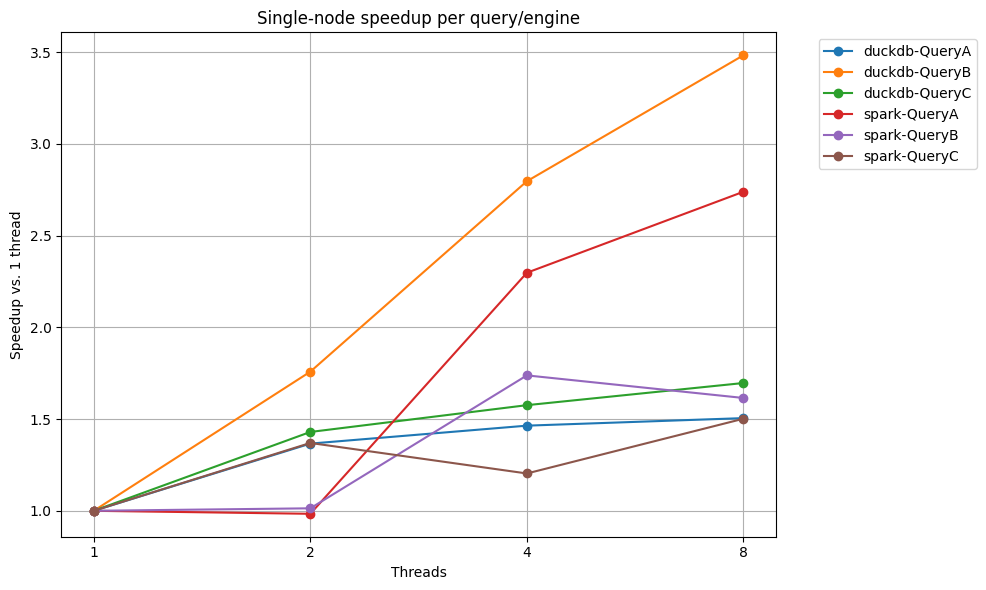

In [5]:
import time
import pandas as pd
import polars as pl
import duckdb
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as F, Window
from memory_profiler import memory_usage

DATA_PATH = "social_media_data.parquet"
THREADS_TO_TEST = [1, 2, 4, 8]

_dim_pd = pd.DataFrame({
    "category": ["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"],
    "weight": [1.2, 0.9, 1.1, 1.0, 1.05, 0.95, 1.15]
})
_dim_pl = pl.from_pandas(_dim_pd)

df_pd = pd.read_parquet(DATA_PATH)
df_pl = pl.read_parquet(DATA_PATH)

_duck = duckdb.connect()
_duck.execute(f"CREATE OR REPLACE TABLE posts AS SELECT * FROM '{DATA_PATH}'")
_duck.register("dim_category", _dim_pd)

spark = None
df_spark = None
_dim_spark = None


def query_a_pd():
    return df_pd.groupby("category").agg({"likes": "mean", "views": "mean"})

def query_a_pl():
    return df_pl.group_by("category").agg([pl.col("likes").mean(), pl.col("views").mean()])

def query_a_duck():
    return _duck.execute("""
        SELECT category, avg(likes) AS avg_likes, avg(views) AS avg_views
        FROM posts
        GROUP BY category
    """).fetch_df()

def query_a_spark():
    return df_spark.groupBy("category").agg(F.avg("likes"), F.avg("views")).collect()


def query_b_pd():
    return (
        df_pd.sort_values("timestamp")
        .assign(
            likes_rank=df_pd.groupby("category")["likes"].rank(method="first"),
            views_dense_rank=df_pd.groupby("category")["views"].rank(method="dense"),
        )
        .head(100)
    )

def query_b_pl():
    return (
        df_pl.sort("timestamp")
        .with_columns([
            pl.col("likes").rank("ordinal").over("category").alias("likes_rank"),
            pl.col("views").rank("dense").over("category").alias("views_dense_rank"),
        ])
        .head(100)
    )

def query_b_duck():
    return _duck.execute("""
        SELECT category, timestamp, likes, views,
               rank() OVER (PARTITION BY category ORDER BY likes) AS likes_rank,
               dense_rank() OVER (PARTITION BY category ORDER BY views) AS views_dense_rank
        FROM posts
        ORDER BY timestamp
        LIMIT 100
    """).fetch_df()

def query_b_spark():
    return (
        df_spark
        .withColumn("likes_rank", F.rank().over(Window.partitionBy("category").orderBy("likes")))
        .withColumn("views_dense_rank", F.dense_rank().over(Window.partitionBy("category").orderBy("views")))
        .limit(100)
        .collect()
    )


def query_c_pd():
    return (
        df_pd.merge(_dim_pd, on="category")
        .query("views > 10000 and likes > 100")
        .groupby("category")
        .agg({"weight": "mean", "likes": "sum"})
    )

def query_c_pl():
    return (
        df_pl.join(_dim_pl, on="category")
        .filter((pl.col("views") > 10_000) & (pl.col("likes") > 100))
        .group_by("category")
        .agg([pl.col("weight").mean(), pl.col("likes").sum()])
    )

def query_c_duck():
    return _duck.execute("""
        SELECT p.category, avg(d.weight) AS avg_weight, sum(p.likes) AS total_likes
        FROM posts p
        JOIN dim_category d USING (category)
        WHERE p.views > 10000 AND p.likes > 100
        GROUP BY p.category
    """).fetch_df()

def query_c_spark():
    local_dim = spark.createDataFrame(_dim_pd) 
    return (
        df_spark.join(local_dim, on="category")
        .filter((F.col("views") > 10000) & (F.col("likes") > 100))
        .groupBy("category")
        .agg(F.avg("weight"), F.sum("likes"))
        .collect()
    )

QUERIES = {
    "QueryA": {"pandas": query_a_pd, "polars": query_a_pl, "duckdb": query_a_duck, "spark": query_a_spark},
    "QueryB": {"pandas": query_b_pd, "polars": query_b_pl, "duckdb": query_b_duck, "spark": query_b_spark},
    "QueryC": {"pandas": query_c_pd, "polars": query_c_pl, "duckdb": query_c_duck, "spark": query_c_spark},
}


def _set_duck_threads(n):
    _duck.execute(f"PRAGMA threads={n}")

def _rebuild_spark(n):
    global spark, df_spark
    try:
        if 'spark' in globals() and spark:
            spark.stop()
            time.sleep(2)
    except:
        pass

    spark = SparkSession.builder \
        .appName("BenchmarkLab") \
        .master(f"local[{n}]") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .config("spark.sql.shuffle.partitions", "4") \
        .config("spark.driver.maxResultSize", "2g") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .getOrCreate()
    
    spark.sparkContext.setLogLevel("ERROR")
    df_spark = spark.read.parquet(DATA_PATH)

def _bench(run_fn, engine):
    t0 = time.time()
    
    if engine == "spark":
        try:
            run_fn()
            elapsed = time.time() - t0
            peak_mem = 0.0
        except Exception as e:
            print(f"!!! SPARK ERROR: {e}")
            elapsed = 0.0
            peak_mem = 0.0
    else:
        mem_trace, _ = memory_usage((run_fn, (), {}), retval=True, include_children=True, max_iterations=1)
        elapsed = time.time() - t0
        peak_mem = max(mem_trace)
        
    return elapsed, peak_mem


results = []

print("Starting benchmark")

for engine in ["pandas", "polars", "duckdb", "spark"]:
    thread_options = THREADS_TO_TEST if engine in ("duckdb", "spark") else [None]
    
    for threads in thread_options:
        if engine == "duckdb":
            _set_duck_threads(threads)
        if engine == "spark":
            try:
                _rebuild_spark(threads)
            except Exception as e:
                print(f"Cannot run Spark ({threads} threads): {e}")
                continue

        for qname, registry in QUERIES.items():
            fn = registry[engine]
            try:
                elapsed, peak_mem = _bench(fn, engine)
                
                results.append({
                    "engine": engine,
                    "threads": threads or 1,
                    "query": qname,
                    "time_s": round(elapsed, 3),
                    "peak_mb": round(peak_mem, 2),
                })
                print(f"{engine} | {qname} | threads={threads or 1} | time={elapsed:.3f}s | peak_mb={peak_mem:.2f}")
            except Exception as e:
                print(f"CRASH: {engine} - {qname}: {e}")


benchmark_df = pd.DataFrame(results)
print("\nResults:")
print(benchmark_df)

if not benchmark_df.empty:
    plot_df = benchmark_df[benchmark_df["threads"] >= 1]
    fig, ax = plt.subplots(figsize=(10, 6))
    for (engine, query), grp in plot_df.groupby(["engine", "query"]):
        if len(grp) > 1: 
            base = grp.loc[grp["threads"] == grp["threads"].min(), "time_s"].iloc[0]
            if base > 0:
                ax.plot(grp["threads"], base / grp["time_s"], marker="o", label=f"{engine}-{query}")

    ax.set_xlabel("Threads")
    ax.set_ylabel("Speedup vs. 1 thread")
    ax.set_xscale("log", base=2)
    ax.set_xticks(THREADS_TO_TEST)
    ax.set_xticklabels(THREADS_TO_TEST)
    ax.set_title("Single-node speedup per query/engine")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

### Task 2: Spark on Cluster

**Goal**: Compare Single Node performance vs. Spark on a Cluster.

**Instructions**:
1.  **Infrastructure**: Use the infrastructure from **Phase 1** (Google Dataproc). You may need to modify your Terraform code to adjust the cluster configuration (e.g., number of worker nodes).
2.  **Environment**: The easiest way to run this is via **Google Workbench** connected to your Dataproc cluster.
3.  **Upload Data**: Upload the generated `social_media_data.parquet` to HDFS or GCS.
    -   **Tip**: For better performance, consider **partitioning** the data (e.g., by `category` or `date`) when saving it to the distributed storage. This allows Spark to optimize reads.
4.  **Run Queries**: Run your PySpark queries from Task 1 on the cluster.
5.  **Scalability Test**: 
    -   Run the queries with different numbers of **worker nodes** (e.g., 2, 3, 4).
    -   You can achieve this by resizing the cluster (manually or via Terraform) or by configuring the number of executors in Spark.
6.  **Analyze**:
    -   How does the cluster performance compare to your local machine?
    -   Did adding more nodes/executors linearly improve performance?
    -   **Tip**: If Spark is slower than single-node engines, consider **increasing the dataset size** (e.g., generate 10M+ records or duplicate the data). Spark's overhead is significant for small data, and its true power appears when data exceeds single-node memory.

In [ ]:
spark.stop()

In [55]:
_dim_pd = pd.DataFrame({
    "category": ["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"],
    "weight": [1.2, 0.9, 1.1, 1.0, 1.05, 0.95, 1.15]
})
def query_a_spark(df_spark):
    return df_spark.groupBy("category").agg(F.avg("likes"), F.avg("views")).collect()
def query_b_spark(df_spark):
    return (
        df_spark
        .withColumn("likes_rank", F.rank().over(Window.partitionBy("category").orderBy("likes")))
        .withColumn("views_dense_rank", F.dense_rank().over(Window.partitionBy("category").orderBy("views")))
        .limit(100)
        .collect()
    )
def query_c_spark(df_spark):
    return (
        df_spark.join(_dim_spark, on="category")
        .filter((F.col("views") > 10000) & (F.col("likes") > 100))
        .groupBy("category")
        .agg(F.avg("weight"), F.sum("likes"))
        .collect()
    )
QUERIES_SPARK = {
    "QueryA": {"spark": query_a_spark},
    "QueryB": {"spark": query_b_spark},
    "QueryC": {"spark": query_c_spark},
}

In [56]:
import time
import pandas as pd
from memory_profiler import memory_usage
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F, Window

def run_spark_cluster_benchmark(spark, exec_num, path):
    global _dim_spark

    df_spark = spark.read.parquet(path)
    _dim_spark = spark.createDataFrame(_dim_pd)

    def _bench(run_fn):
        t0 = time.time()
        mem_trace, _ = memory_usage((run_fn, (), {}), retval=True, include_children=True, max_iterations=1)
        elapsed = time.time() - t0
        return elapsed, max(mem_trace)
    
    results = []
    for qname, registry in QUERIES_SPARK.items():
        fn = registry["spark"]
        print(f"Running query {qname} on cluster...")
        elapsed, peak_mem = _bench(lambda: fn(df_spark))
        results.append({
            "query": qname,
            "time_s": round(elapsed, 3),
            "peak_mb": round(peak_mem, 2)
        })
        print(f"{qname} | time={elapsed:.3f}s | peak_mb={peak_mem:.2f}")

    benchmark_df = pd.DataFrame(results)
    display(benchmark_df)

    fig, ax = plt.subplots(figsize=(8,5))
    for query, grp in benchmark_df.groupby("query"):
        base = grp["time_s"].iloc[0]
        ax.bar(query, base)
    ax.set_ylabel("Time (s)")
    ax.set_title(f"PySpark cluster benchmark - {exec_num} executors")
    plt.xticks(rotation=45)
    plt.show()
    
    spark.stop()
    print("Spark session stopped.")

    return benchmark_df

In [ ]:
## Run with 2 executors

In [57]:
# 2 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 2)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:13:57 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:13:57 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:13:57 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:13:57 INFO SparkEnv: Registering OutputCommitCoordinator


In [60]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


Running query QueryA on cluster...


[Stage 1:============================================>              (3 + 1) / 4]

QueryA | time=9.325s | peak_mb=1433.89
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=20.860s | peak_mb=1441.54
Running query QueryC on cluster...


[Stage 11:=================================================>        (6 + 1) / 7]

QueryC | time=8.737s | peak_mb=1450.69


,query,time_s,peak_mb
0,QueryA,9.325,1433.89
1,QueryB,20.860,1441.54
2,QueryC,8.737,1450.69


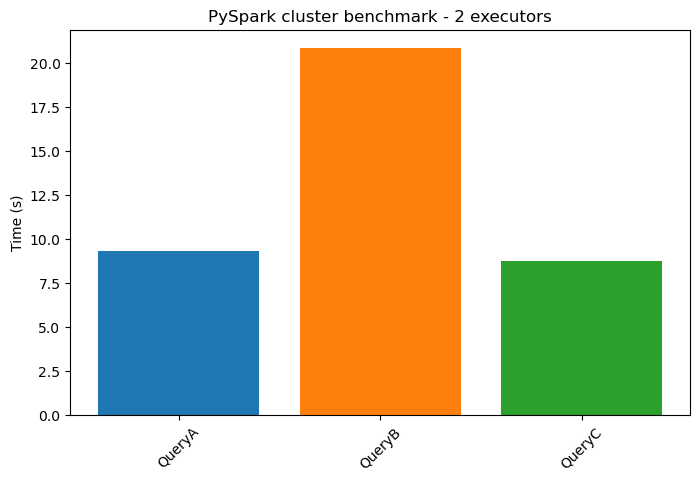

Spark session stopped.


In [61]:
try:
    run_spark_cluster_benchmark(spark, 2, DATA_PATH)
except:
    spark.stop()

In [ ]:
## 3 Executors

In [62]:
# 3 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 3)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:15:25 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:15:25 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:15:25 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:15:25 INFO SparkEnv: Registering OutputCommitCoordinator


In [64]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=======================================>                   (4 + 2) / 6]

QueryA | time=10.408s | peak_mb=1465.28
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=18.060s | peak_mb=1467.39
Running query QueryC on cluster...


[Stage 11:========================>                                 (3 + 4) / 7]

QueryC | time=7.383s | peak_mb=1472.18


,query,time_s,peak_mb
0,QueryA,10.408,1465.28
1,QueryB,18.060,1467.39
2,QueryC,7.383,1472.18


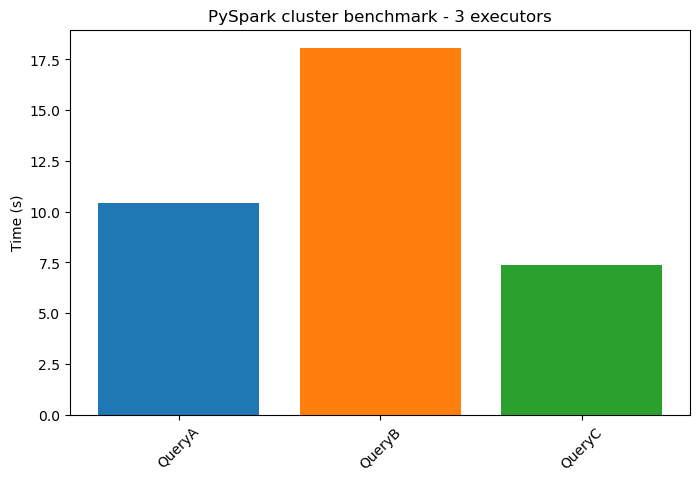

Spark session stopped.


In [65]:
try:
    run_spark_cluster_benchmark(spark, 3, DATA_PATH)
except:
    spark.stop()

In [ ]:
## 4 Executors

In [66]:
# 4 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 4)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:16:46 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:16:46 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:16:46 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:16:46 INFO SparkEnv: Registering OutputCommitCoordinator


In [69]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:============================================>              (6 + 2) / 8]

QueryA | time=9.124s | peak_mb=1474.71
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=18.306s | peak_mb=1478.34
Running query QueryC on cluster...


QueryC | time=9.780s | peak_mb=1480.90


,query,time_s,peak_mb
0,QueryA,9.124,1474.71
1,QueryB,18.306,1478.34
2,QueryC,9.780,1480.90


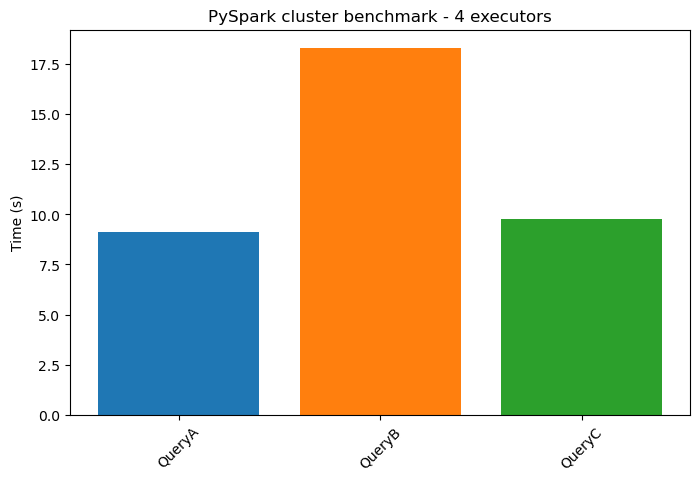

Spark session stopped.


In [70]:
try:
    run_spark_cluster_benchmark(spark, 4, DATA_PATH)
except:
    spark.stop()

In [ ]:
## Testing on Partitioned DATA

In [3]:
output_path = "gs://tbd-2025z-319020-dataproc-staging/social_media_data_partitioned/"
DATA_PATH = "gs://tbd-2025z-319020-dataproc-staging/social_media_data.parquet"

spark = SparkSession.builder.getOrCreate()

df_spark = spark.read.parquet(DATA_PATH)
df_doubled = df_spark.union(df_spark)

df_doubled.write \
    .mode("overwrite") \
    .partitionBy("category", "location") \
    .parquet(output_path)

In [ ]:
## TESTING 2 Executors

In [71]:
input_path = "gs://tbd-2025z-319020-dataproc-staging/social_media_data_partitioned/"

# 2 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 2)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:19:01 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:19:01 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:19:01 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:19:01 INFO SparkEnv: Registering OutputCommitCoordinator


In [72]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=================================================>       (13 + 2) / 15]

QueryA | time=25.279s | peak_mb=1479.54
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=31.375s | peak_mb=1489.75
Running query QueryC on cluster...


[Stage 11:========================>                                 (3 + 4) / 7]

QueryC | time=15.471s | peak_mb=1485.56


,query,time_s,peak_mb
0,QueryA,25.279,1479.54
1,QueryB,31.375,1489.75
2,QueryC,15.471,1485.56


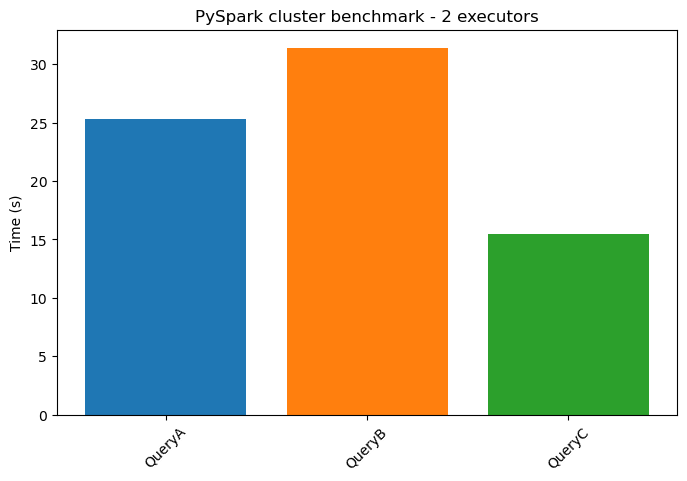

Spark session stopped.


In [73]:
try:
    run_spark_cluster_benchmark(spark, 2, input_path)
except:
    spark.stop()

In [ ]:
## TESTING 3 Executors

In [74]:
# 3 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 3)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:22:28 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:22:28 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:22:28 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:22:28 INFO SparkEnv: Registering OutputCommitCoordinator


In [75]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=================================================>       (13 + 2) / 15]

QueryA | time=23.623s | peak_mb=1491.77
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=31.655s | peak_mb=1483.74
Running query QueryC on cluster...


QueryC | time=14.663s | peak_mb=1490.55


,query,time_s,peak_mb
0,QueryA,23.623,1491.77
1,QueryB,31.655,1483.74
2,QueryC,14.663,1490.55


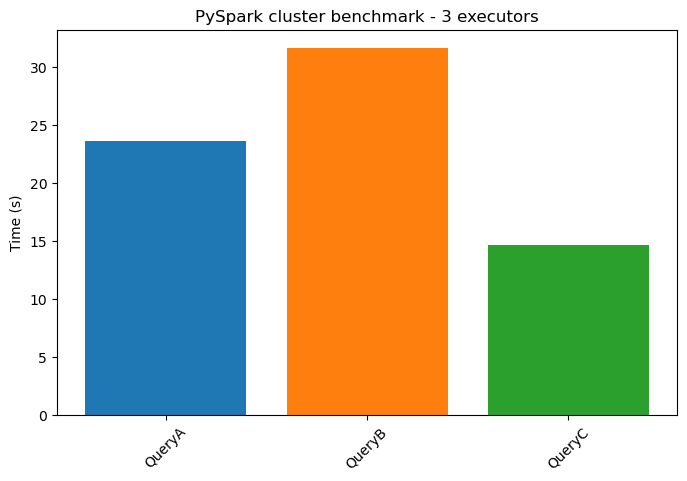

Spark session stopped.


In [76]:
try:
    run_spark_cluster_benchmark(spark, 3, input_path)
except:
    spark.stop()

In [ ]:
## TESTING 4 executors

In [77]:
# 4 Executors
spark = (
    SparkSession.builder
    .appName("BigDataLab2-Cluster")
    .master("yarn")
    .config("spark.executor.instances", 4)
    .config("spark.dynamicAllocation.enabled", "true")
    .getOrCreate()
)

26/01/26 20:24:42 INFO SparkEnv: Registering MapOutputTracker
26/01/26 20:24:42 INFO SparkEnv: Registering BlockManagerMaster
26/01/26 20:24:42 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
26/01/26 20:24:42 INFO SparkEnv: Registering OutputCommitCoordinator


In [79]:
sc = spark._jsc.sc() 
for executor in sc.statusTracker().getExecutorInfos():
    print(executor.host())

tbd-cluster-m.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal
tbd-cluster-w-0.c.tbd-2025z-319020.internal
tbd-cluster-w-1.c.tbd-2025z-319020.internal


[Stage 0:>                                                          (0 + 1) / 1]

Running query QueryA on cluster...


[Stage 1:=====================================================>   (14 + 1) / 15]

QueryA | time=17.949s | peak_mb=1490.21
Running query QueryB on cluster...


[Stage 6:>                                                          (0 + 1) / 1]

QueryB | time=31.092s | peak_mb=1496.06
Running query QueryC on cluster...


[Stage 11:=========================================>                (5 + 2) / 7]

QueryC | time=14.429s | peak_mb=1493.48


,query,time_s,peak_mb
0,QueryA,17.949,1490.21
1,QueryB,31.092,1496.06
2,QueryC,14.429,1493.48


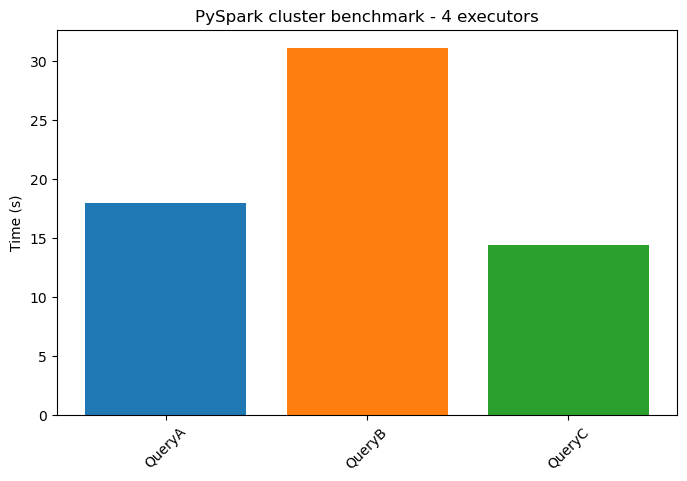

Spark session stopped.


In [80]:
try:
    run_spark_cluster_benchmark(spark, 4, input_path)
except:
    spark.stop()

#### Analysis
This analysis is made with a disclaimer, that all the work done on the cluster was haively bugy, lagging and not functional even though we have updated the instances from `e2-standard-2` to `e2-standard-4`. The kernel was not stable, constantly crashing.

#### tl;dr
Spark on cluster is much slower compared to the local machine runs.
Adding more executors did not improve performance in a linear manner.

#### Linear Scalability Analysis
Adding more executors did **not** result in linear performance gains. In distributed computing, linear scaling would mean doubling executors halves the time ($T_{new} = T_{old} / 2$). This is not what we have encountered.

#### Performance Scaling (10M Records)
| Query | 2 Executors | 4 Executors | Speedup % | Linear? |
| :--- | :--- | :--- | :--- | :--- |
| **Query A** | 25.28s | 17.95s | ~29.0% | **No** (Sub-linear) |
| **Query B** | 31.38s | 31.09s | ~0.9% | **No** (Stagnant) |
| **Query C** | 15.47s | 14.43s | ~6.7% | **No** (Negligible) |

#### Analysis of Anomalies:
* **Query B Bottleneck:** Query B is essentially "scaling-proof." Since the time remains identical (~31s) regardless of whether we have used 2, 3, or 4 executors, this query is likely hitting a **Shuffle Partition bottleneck** or a **Single-Core operation** (like `collect()` or a non-parallelizable window function).

---

#### Impact of Partitioning
We have the 10M records tests partitioned on `category` and `location`.
* **Data Skew Potential:** If the "category" or "location" values are not evenly distributed, some executors might be working harder than others (stragglers). 
* **Stage Count:** With 2 executors, those tasks are queued. With 4 executors, more tasks run in parallel, which is why Query A showed the best improvement among all queries.

---

#### Summary Table

| Data Size | Configuration | Query A (s) | Query B (s) | Query C (s) |
| :--- | :--- | :--- | :--- | :--- |
| **5M** | 2 Executors | 9.33 | 20.86 | 8.74 |
| **5M** | 4 Executors | 9.12 | 18.31 | 9.78 |
| **10M (Part)** | 2 Executors | 25.28 | 31.38 | 15.47 |
| **10M (Part)** | 4 Executors | 17.95 | 31.09 | 14.43 |

### Task 3: Execution Modes & Analysis

**Goal**: Deep dive into execution models and limitations.

**Instructions**:
1.  **Lazy vs. Eager vs. Streaming**:
    -   Use **Polars**. Compare the **Execution Time** and **Peak Memory** of:
        -   Eager execution (`read_parquet` -> filter).
        -   Lazy execution (`scan_parquet` -> filter -> `collect()`).
        -   Streaming execution (`scan_parquet` -> filter -> `collect(streaming=True)`).
2.  **Polars Limitations**:
    -   Identify a scenario where Polars might struggle compared to Spark (e.g., memory limits).
3.  **Decision Boundary**:
    -   Based on your findings, when would you recommend switching from a single-node tool (Polars/DuckDB) to a distributed engine (Spark)?

In [15]:
from memory_profiler import profile, memory_usage
import polars as pl
TRIES = 100
from functools import partial
%load_ext memory_profiler
import timeit

PARQUET_FILE="social_media_data.parquet"

def measure_time_and_memory(func, tries=100, *args, **kwargs):
    baseline = memory_usage(-1, interval=0.1, timeout=1)[0]
    
    mem_usage, retval = memory_usage((func, args, kwargs), max_usage=True, retval=True)
    
    peak_usage = mem_usage[0] if isinstance(mem_usage, list) else mem_usage
    incremental = peak_usage - baseline
    
    time = timeit.timeit(partial(func, *args, **kwargs), number=tries) / tries
    
    print(f"Peak: {peak_usage} MiB | Added: {incremental} MiB | Time: {time}s")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### 1. Eeager execution

In [16]:
def eager_execution():
    df = pl.read_parquet(PARQUET_FILE)
    
    result = (df
        .filter(pl.col("views") > 500_000)
        .filter(pl.col("likes") > 5000)
        .group_by("category")
        .agg([
            pl.col("likes").mean().alias("average_likes"),
            pl.col("views").mean().alias("average_views"),
            pl.len().alias("posts_count")
        ])
        .sort("average_likes", descending=True)
    )
    return result
measure_time_and_memory(eager_execution, tries=10)

Peak: 1717.21875 MiB | Added: 1622.359375 MiB | Time: 0.21967681659152732s


### 2. Lazy Execution

In [17]:
def lazy_execution():
    df = pl.scan_parquet(PARQUET_FILE)
    
    result = (df
        .filter(pl.col("views") > 500_000)
        .filter(pl.col("likes") > 5000)
        .collect()
    )
    return result

measure_time_and_memory(lazy_execution, tries=10)

Peak: 2188.84375 MiB | Added: 550.609375 MiB | Time: 0.12882272920105606s


### 3. STREAMING EXECUTION

In [18]:
def streaming_execution():
    df = pl.scan_parquet(PARQUET_FILE)
    
    result = (df
        .filter(pl.col("views") > 500_000)
        .filter(pl.col("likes") > 5000)
        .collect(engine="streaming")
    )
    return result

measure_time_and_memory(streaming_execution, tries=10)

Peak: 2361.375 MiB | Added: 420.1875 MiB | Time: 0.15040737499948592s


Tested on 5 milion generated rows. 
Run locally due to the fact of constantly breaking and very slow dataproc on GCP, even tho we have changed the instances.
```
e2-standrad-2 -> e2-standard-4
```

Machine used: macbook air m1 2020 16GB RAM. 

---

The following table summarizes the performance metrics. The "Peak" values show the total process footprint, the Added Memory column highlights the actual resource cost of the operation itself.

| Engine | Time (s) | Peak Memory (MiB) | Added Memory (MiB) |
| :--- | :--- | :--- | :--- |
| **Eager** | 0.2197 | 1717.22 | 1622.36 |
| **Lazy** | 0.1288 | 2188.84 | 550.61 |
| **Streaming** | 0.1504 | 2361.38 | 420.19 |

### 1. Analysis
Lazy and Streaming show similar performance because the dataset fits comfortably in RAM. However, the Eager mode is significantly more memory-intensive, adding over 1.6GB to the baseline. While this runs fine on the local machine, testing on a standard 8GB machine on GCP resulted in a kernel crash for Eager execution. Streaming engine—adding only ~420MB successfully processed the data by handling it in chunks (on the 16GB e2-standard-4 machine). On the local machine we can clearly verify the diferences of memory consumption.

### 2. Polaris Limits
Polars is constrained by the physical RAM available on a single node. Even when using the streaming engine, Polars can struggle in scenarios involving:
- Large Intermediate Results: Operations like massive joins or group_by on high-cardinality columns may still require materializing data that exceeds a memory.
- Memory Spillage: Unlike Spark, which is designed to spill to disk across a cluster, Polars is a scaled verticaly. If the task exceeds the limits of the machine's RAM and swap space, the process will be terminated.

### 3. Decision Boundary: When to Switch to Spark
Based on the experiments, the recommendation for choosing a processing engine depends on dataset scale and infrastructure. When to use:

#### Polars / DuckDB (Single node)
- Dataset fits in memory:
    A safe margin is $<50\%$ of RAM for eager/lazy, or up to $<250\%$ of RAM when utilizing the streaming engine. 

- Vertical Scaling:
    You have the option to increase the RAM on a single instance.

- Simplicity: 
    You prioritize development speed and low latency over massive scalability.

- No complex iterative processing:
    The workload doesn't require the advanced parallelization Spark provides for iterative algorithms. 

#### Spark (Distributed)
- Extreme Scale: The dataset size vastly exceeds the memory of any single available node.

- Fault Tolerance: You are running long-duration jobs where a single node failure shouldn't restart the entire process (Spark restores lost partitions via lineage).

- Distributed Operations: You need to perform complex shuffles or joins across a network of machines.





